In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
import helpers
from helpers import *
import pickle
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
from IPython.display import Image
from collections import Counter
import random

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
%pwd

'/Users/thomasspringett/github/heartrate'

In [3]:
# Maximum heart rate is estimated by 220 - age. This is the most common definition and is confirmed by data. 
age = 63 
max_hr = 220-age

In [26]:
#Dictionaries are defined for Mayo Clinic, CDC and Polar (tm) heart rate zones: 
mayo_limits = {'moderate_low':0.50*max_hr,'moderate_hi':0.7*max_hr,'intensity_low':0.70*max_hr,'intensity_hi':0.85*max_hr}
cdc_limits = {'moderate_low':0.64*max_hr,'moderate_hi':0.76*max_hr,'intensity_low':0.76*max_hr,'intensity_hi':0.93*max_hr}
polar_limits = {'zone1':0.6*max_hr,'zone2':0.7*max_hr,'zone3':0.80*max_hr,'zone4':0.9*max_hr,'zone5':1*max_hr}

In [5]:
# The dataset for this project consist of heart rate data collected over 4 years from an Apple watch. 
# the person is a 63 year old white male during various physical activities: biking, walking, skiing. 
csv_file = 'data/HeartRateData.csv'
df_raw = pd.read_csv(csv_file)
df_raw=df_raw.drop('DateTime',1)
#df_raw.head(3)

In [6]:
print (round(df_raw.BPM.describe()))

count    349768.0
mean         78.0
std          24.0
min          30.0
25%          61.0
50%          69.0
75%          86.0
max         215.0
Name: BPM, dtype: float64


In [7]:
#To improve execution times, a random sample of 10,000 from the population of 349,768 is drawn. By comparing the 
#percentiles of the population above to that of the sample below, it can be seen the distribution is not changed. 
df_s=random.sample(list(df_raw.BPM), 10000)
df_sample = pd.DataFrame(df_s)
df_sample.columns=['BPM']
print (round(df_sample.describe()))

           BPM
count  10000.0
mean      78.0
std       24.0
min       31.0
25%       61.0
50%       69.0
75%       86.0
max      215.0


In [117]:
def plot_data_histo(totals): 
    xref = [max_hr]
    ref_colors=['r']
    plt.figure(figsize=(10,5))
    for ref, c in zip(xref,ref_colors):
        plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
    plt.legend()
    #plt.figure(figsize=(10,5))
    plt.grid(True)
    bin=100
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()
    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    plt.xlabel('Beats/Minute')
    plt.ylabel('Count')
    plt.title('Raw Heart Rate Distribution')
    #plt.ylim(0,35000)
    #plt.xlim(30,200)
    plt.hist(df_raw.BPM, bins=range(35, 205+2, 2))
    plt.savefig('./plots/raw_histo.png')
    ax = plt.figure() 
    pickle.dump(ax,open('./plots/raw_histo.png','wb'))

    plt.show()
    return ax

In [9]:
def hr_cluster_histogram(df): 
    
    if  'Label' in df: 
        df.drop("Label",axis='columns',inplace=True)
    kmeans = KMeans(n_clusters=5)
    model = kmeans.fit(df)
    centers = np.round(model.cluster_centers_,0)
    print ("Percent of Values in each zone: ")
    #print ("\nCluster {}: {}".format(k,centers))
    labels = kmeans.predict(df)
    print ("KMeans Labels: ",np.unique(labels))   
   
    df.insert(1,"Label",labels)

    clusterCounts(labels)

    xref = [max_hr]
    ref_colors=['r']

    #for ref, c in zip(xref,ref_colors):
    #    plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
        
    zone1 = df.loc[df.Label ==0, 'BPM']
    zone2 = df.loc[df.Label ==1, 'BPM']
    zone3 = df.loc[df.Label ==2, 'BPM']
    zone4 = df.loc[df.Label ==3, 'BPM']
    zone5 = df.loc[df.Label ==4, 'BPM']
    
    
    plt.figure(figsize=(10,5))
    # xticks = np.linspace(30, 200, 50)
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(bwhich='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    bin = 20
    
    #plt.grid(True)
    plt.title('Cluster Heart Rate Distribution')
    plt.hist(zone1, **kwargs, color='b', label='Cluster 1', bins=range(35, 205, 2))
    plt.hist(zone2, **kwargs, color='c', label='Cluster 2', bins=range(35, 205, 2))
    plt.hist(zone3, **kwargs, color='g', label='Cluster 3', bins=range(35, 205, 2))
    plt.hist(zone4, **kwargs, color='y', label='Cluster 4', bins=range(35, 205, 2))
    plt.hist(zone5, **kwargs, color='r', label='Cluster 5', bins=range(35, 205, 2))
    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    #plt.xlim(30,200)
    #plt.hist(df_raw.BPM, bins=range(35, 205, 2))
    plt.legend()
    plt.savefig('./plots/cluster_histo.png')
    plt.show()

In [43]:
def hr_zone_histogram(df): 
    
    clusterCounts(df['Polar_Zone'])
    #Histogram of the number of missing values per column (featrure).
    xref = [max_hr]
    ref_colors=['r','g','y','b']

    #for ref, c in zip(xref,ref_colors):
    #    plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
        
    zone1 = df.loc[df.Polar_Zone == 'zone1', 'BPM']
    zone2 = df.loc[df.Polar_Zone == 'zone2', 'BPM']
    zone3 = df.loc[df.Polar_Zone == 'zone3', 'BPM']
    zone4 = df.loc[df.Polar_Zone == 'zone4', 'BPM']
    zone5 = df.loc[df.Polar_Zone == 'zone5', 'BPM']
    
    
    plt.figure(figsize=(10,5))
    # xticks = np.linspace(30, 200, 50)
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    bin = 20 
    
    #plt.grid(True)
    plt.title('Polar(tm) Zone Heart Rate Distribution')
    plt.hist(zone1, **kwargs, color='g', label='Zone 1',bins=bin)
    plt.hist(zone2, **kwargs, color='b', label='Zone 2',bins=bin)
    plt.hist(zone3, **kwargs, color='r', label='Zone 3',bins=bin)
    plt.hist(zone4, **kwargs, color='c', label='Zone 4',bins=bin)
    plt.hist(zone5, **kwargs, color='y', label='Zone 5',bins=bin)
    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    plt.xlim(30,200)
    plt.legend()
    plt.savefig('./plots/zone_histo.png')
    plt.show()

In [11]:
hardware_limit = 210
df_limit = df_sample[(df_sample < hardware_limit)]
num_screened = df_sample.shape[0]-df_limit.shape[0]
print ("Applying hardware limit of {}bpm resulted in dropping {} data points.".format(hardware_limit,num_screened))

Applying hardware limit of 210bpm resulted in dropping 0 data points.


 Note that with KMeans clustering the data will not be split into training and test sets. Kmeans clustering is not a classification tool. The data is not labeled.

In [12]:

def scree_KMeans_plot(data,num_clusters):
    clusterCenters = [] 
    scores = [] 
    k_values = []
    start = timer()
    for k in range(1,num_clusters):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        #print ("\nCluster {}: {}".format(k,model.cluster_centers_))
        clusterCenters.append(model.cluster_centers_)
        labels = kmeans.predict(data)
        #print ("Cluster Labels: ",np.unique(labels))
        score = -(kmeans.score(data))
        #print ("score: ",round(score/100000000,2))
        scores.append(score)
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Number of Clusters vs KMeans Score')
    plt.savefig('./plots/Cluster_vs_score_plot.png')
    plt.show()
    end = timer() 
    #print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    return k_values, scores, labels

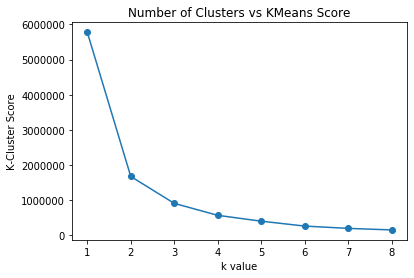

In [13]:
k_values, scores, labels = scree_KMeans_plot(df_sample,9) 

In [14]:
# The elbow method would suggest that most of the improvement in the cluster scores happens prior to k=5.
# The algorithm below allows for selection of k based on the diminishing benefits of increasing clusters. 
# 5 clusters is being chosen, not just by the elbow method above as it also matches up with the 5 zones 
# defined by the Polar (tm) methodology. 

def findK(df,limit): 

    for k in range(len(df)):
        if k == len(df):
           print ("\nEnd of array reached.") 
        elif k == len(df): 
          improvement = 'None'
          print ("end of array reached prior to limit")
          print ("K=0")
        elif k > 0:
          improvement = (round(100*((df[k-1]-df[k])/df[k])))
          #print (k,round(df[k]/100000000,2),improvement)
          if improvement < limit:
                #print ("Improvement of {}% is less than lower limit of {}% for k = {}. k max is {} ".format(improvement,limit,k,len(df)))
                break
    print ("Maximum value of number of clusters (k) is: ",len(df))
    print ("Less than {}% improvement in score after k = {}".format(limit,k))

findK(scores,30) 

Maximum value of number of clusters (k) is:  8
Less than 30% improvement in score after k = 7


In [15]:
print ("KMeans Labels: ",np.unique(labels))     

KMeans Labels:  [0 1 2 3 4 5 6 7]


In [16]:
# The function below calculates the percent of the distribution in each cluster. 
def clusterCounts(labels): 
    #Count number in each cluster for general population 
    clusterDict = collections.Counter(labels)
    clusterSum = sum(clusterDict.values())
    #clusterCounter = Counter(clusterDict.values())

    for key,value in sorted(clusterDict.items()): 
        print (key, ' ->',np.round(100*value/clusterSum),'%')

Percent of Values in each zone: 
KMeans Labels:  [0 1 2 3 4]
0  -> 26.0 %
1  -> 7.0 %
2  -> 52.0 %
3  -> 1.0 %
4  -> 14.0 %


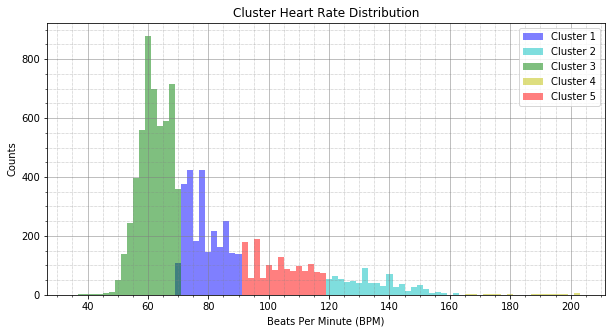

In [17]:
hr_cluster_histogram(df_sample)

# Labels 0-4 are renumbered as clusters 1-5 in the histogram. 

In [ ]:
hr_cluster_histogram(df_sample)

In [30]:
def assignZone(value):
    if (value <= polar_limits['zone1']): 
        return "zone1"
    elif (value > polar_limits['zone1']) and (value <= polar_limits['zone2']):
        return "zone2"
    elif (value > polar_limits['zone2']) and (value <= polar_limits['zone3']):
        return  "zone3"
    elif (value > polar_limits['zone3']) and (value <= polar_limits['zone4']):
        return  "zone4"    
    elif (value > polar_limits['zone4']) and (value <= polar_limits['zone5']):
        return "zone5"
    else:
        return 'nan'
        print ('\nvalue is nan: ',value)
   

In [32]:
df_zones=df_sample.copy()
df_zones['Polar_Zone'] = df_zones.BPM.apply(assignZone)
print (df_zones.shape)
df_zones.head()

(10000, 3)


,BPM,Label,Polar_Zone
0,72,0,zone1
1,62,2,zone1
2,68,2,zone1
3,60,2,zone1
4,68,2,zone1


In [33]:
#Checking for Zone assignment: 
df_zones['Polar_Zone'].unique()

array(['zone1', 'zone2', 'zone3', 'zone4', 'nan', 'zone5'], dtype=object)

In [37]:
df2 = df_zones.copy() 
print ("The percentiles for Polar Zones:")
clusterCounts(df2['Polar_Zone'])


The percentiles for Polar Zones:
nan  -> 1.0 %
zone1  -> 80.0 %
zone2  -> 8.0 %
zone3  -> 6.0 %
zone4  -> 4.0 %
zone5  -> 2.0 %


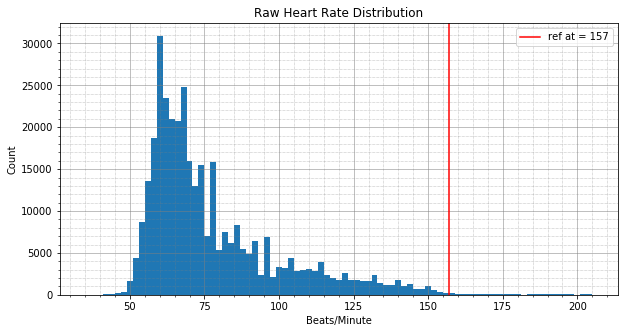

<Figure size 432x288 with 0 Axes>

In [118]:
my = plot_data_histo(df_sample.BPM)

Note: you may need to restart the kernel to use updated packages.


In [39]:
df2.head()

,BPM,Label,Polar_Zone
0,72,0,zone1
1,62,2,zone1
2,68,2,zone1
3,60,2,zone1
4,68,2,zone1


nan  -> 1.0 %
zone1  -> 80.0 %
zone2  -> 8.0 %
zone3  -> 6.0 %
zone4  -> 4.0 %
zone5  -> 2.0 %


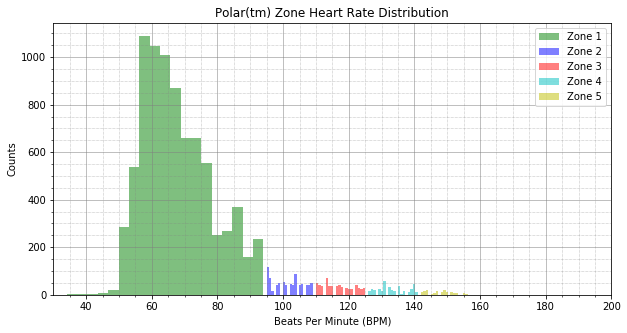

In [44]:
hr_zone_histogram(df2)

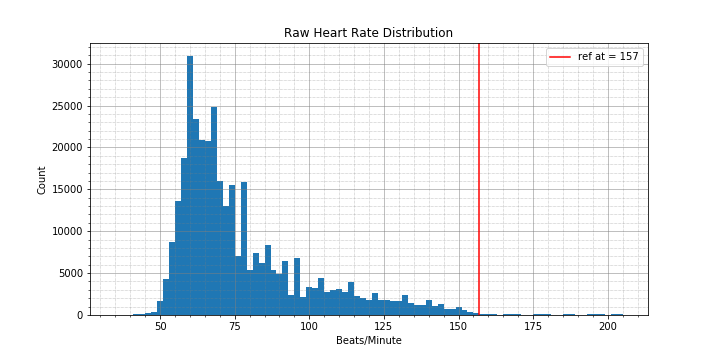

In [45]:
Image('./plots/raw_histo.png')

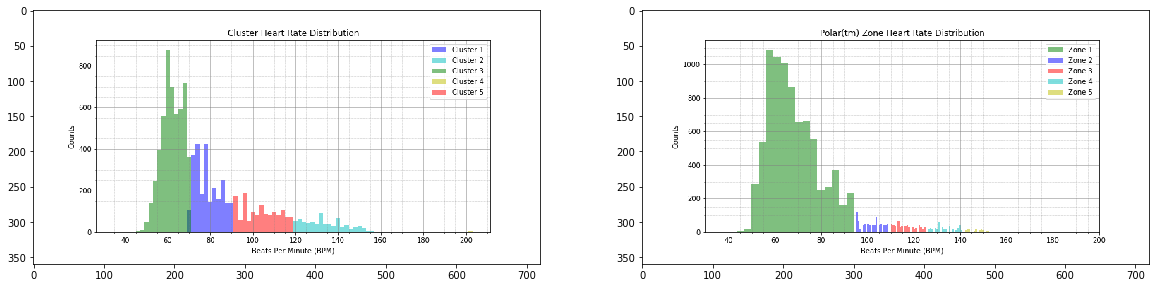

In [191]:
#import matplotlib.image as mpimg
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import imageio
import matplotlib.pyplot as plt
img1  =  imageio.imread('./plots/cluster_histo.png')
img2 = imageio.imread('./plots/zone_histo.png') 


plt.rcParams["figure.figsize"] = (20,20)


fig,(ax1,ax2) = plt.subplots(1,2)
#plt.subplot(2,1,1)
#plt.figure()

ax1.imshow(img1)                     
#plt.subplot(212) 
ax2.imshow(img2) 


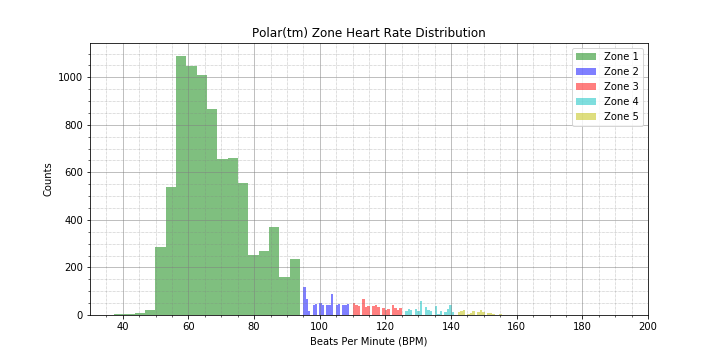

In [47]:
Image('./plots/zone_histo.png')

In [48]:
print (df2.head())
df2.BPM.head()


   BPM  Label Polar_Zone
0   72      0      zone1
1   62      2      zone1
2   68      2      zone1
3   60      2      zone1
4   68      2      zone1


0    72
1    62
2    68
3    60
4    68
Name: BPM, dtype: int64

In [49]:

def silhouetteScore(df,num_clusters): 
    sil_scores = [] 
    start = timer()
    range_n_clusters = list(range(2,num_clusters))
    for n_clusters in range_n_clusters:
        #kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(df)
        score = silhouette_score(df,cluster_labels)
        sil_scores.append(score)
        print("\nFor n_clusters = {}, silhouette score is {}".format(n_clusters, score))
        end=timer()
        print(f"Function in {(end - start)/60:0.1f} minutes")
    print ("\nFinished!")
    return sil_scores

In [57]:
%%time
sil_scores = silhouetteScore(df2.BPM.values.reshape(-1,1),10)


For n_clusters = 2, silhouette score is 0.7078071924900833
Function in 0.0 minutes

For n_clusters = 3, silhouette score is 0.636528124884956
Function in 0.1 minutes

For n_clusters = 4, silhouette score is 0.5867685401842256
Function in 0.1 minutes

For n_clusters = 5, silhouette score is 0.5934420031170701
Function in 0.1 minutes

For n_clusters = 6, silhouette score is 0.561879351297126
Function in 0.1 minutes

For n_clusters = 7, silhouette score is 0.557962893846264
Function in 0.2 minutes

For n_clusters = 8, silhouette score is 0.5488626306787056
Function in 0.2 minutes

For n_clusters = 9, silhouette score is 0.5443391799530124
Function in 0.2 minutes

Finished!
CPU times: user 10.7 s, sys: 1.48 s, total: 12.2 s
Wall time: 12.2 s


In [58]:
#pickle.dump(sil_scores,open('data/silhouetteScores','wb'))
silhouette = pickle.load(open('data/silhouetteScores', 'rb'))
print ("Sil Scores: ",silhouette)

Sil Scores:  [0.7019536815859312, 0.6147305730470606, 0.5854387570593567, 0.5873391956080526, 0.567917391844778, 0.5562202011210109, 0.5537230074225479, 0.5577654335791888, 0.5514605559203648, 0.5564664141356312, 0.5433096404868549, 0.545879403770531, 0.5697131501461868]


In [59]:
def silhouette_plot(scores, k_values):

    plt.ylabel('Silhouette Score')
    plt.xlabel('k value')
    plt.title('Silhouete For Best K')
    plt.ylim=(0.0,1.0)
    plt.grid(True)
    plt.plot(k_values, scores, marker = 'o')
    plt.show()

In [65]:
len(k_values)

8

In [70]:
print (len(k_values), len(silhouette))
print (oftype(k_values))
print (oftype(silhouette))
if len(k_values) > len(silhouette):
    x=len(k_values) - len(silhouette)
    k_values = k_values[:-x]
if len(silhouette) > len(k_values):
    x = len(silhouette) - len(k_values)
    silhouette = silhouette[:-x]
oftype(k_values)
print (len(k_values), len(silhouette))

7 7
None
None
7 7


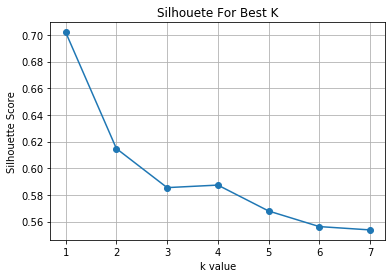

In [71]:
silhouette_plot(silhouette,k_values)

In [ ]:
Image('./plots/raw_histo.png')
Image('./plots/cluster_histo.png')
Image('./plots/zone_histo.png')

In [94]:
ax = plt.subplot(111)
with open('./plots/raw_histo.png','rb') as fid: 
    ax=pickle.load(fid)
plt.show()
#Image('./plots/cluster_histo.png')
#Image('./plots/zone_histo.png')

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

The first step in determining high intensity heart rate zones is to determine maximum heart rate. There are several methods for this: 

1. 200 - 1/2 age. Or 168bpm for a 62 year old. 
2. 220 - age. 0r 158bpm for a 62 year old.
3. Heart Rate Monitor data collected over a period of months with various activities. 
4. Using a treadmill or stationary bike with an ECG. 

Option number 2 is the most common for folks that do not have access to the treadmill and ECG. It will be used for the remainder of the project. 

After the maximum heart rate is determined, target heart rates can be determined: 
1. Target active heart rate: 60-70%. Or 95 to 110 bpm for the 62 year old. 
2. Target Heart Rate is 64% to 76%. CDC. 
3. High Intensity target heart rate is 76-93% (CDC). Or 120 to 146 for the 62 year old. 
 
The heart rate monitor company Polar suggests 5 heart rate zones: 
1. Very light at 50-60% of HRMAX. Boost recovery and prepare for higher zones.
2. Light 60-70%. Improve general endurance and increase capillary density.
2. Moderate at 70-80%. Lactic acid build up,improve efficiency of blood circulation in the heart and muscles
4. Hard 80-90%. Improve speed endurance.
5. Maximum 90-100%. For elite atheletes to further improve speed. 

The Mayo Clinic defines 
1. Moderate intensity as 50-70% of maximum heart rate.
2. Vigorous as 70% to 85%. 